<a href="https://colab.research.google.com/github/Bazinga97/ML_Projects/blob/main/Quora_question_pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target
1. Exploratory data analysis
2. Machine learning models

### **Exploratory Data analysis**

In [7]:
!pip install distance
!pip install fuzzywuzzy

In [8]:
## importing the libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

## Library for pattern matching and manipulation of strings
import re
## Natural language Toolkit is a popular for working human language data
from nltk.corpus import stopwords
## Calculating distance between sequences and similarity scoring
import distance

## For stemming (reducing words to their base )
from nltk.stem import PorterStemmer

## BeautifulSoup is a Python library for pulling data out of HTML and XML files
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

## Fuzzy string matching library, comparing strings based on similarity rather than exact match
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [9]:
df = pd.read_csv("train.csv")

In [11]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Duplicate

~> Total number of question pairs for training: 404290
~> Question pairs are not Similar (is_duplicate = 0): 63.08%
~> Question pairs are Similar (is_duplicate = 1): 36.92%


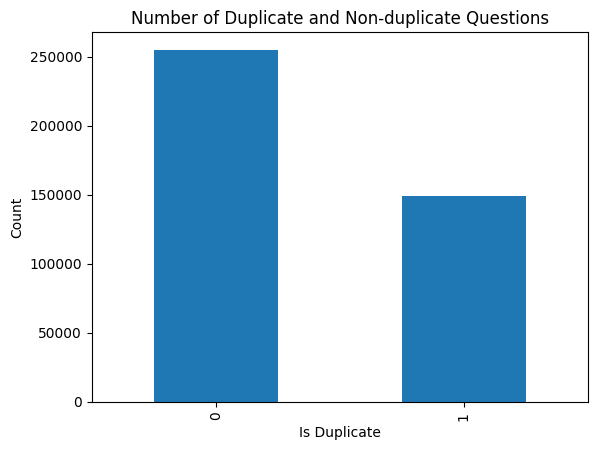

In [13]:
# Count total number of question pairs
total_question_pairs = len(df)

# Calculate percentage of non-similar (is_duplicate = 0) question pairs
non_similar_percentage = 100 - round(df['is_duplicate'].mean() * 100, 2)

# Calculate percentage of similar (is_duplicate = 1) question pairs
similar_percentage = round(df['is_duplicate'].mean() * 100, 2)

# Print details
print('~> Total number of question pairs for training: {}'.format(total_question_pairs))
print('~> Question pairs are not Similar (is_duplicate = 0): {}%'.format(non_similar_percentage))
print('~> Question pairs are Similar (is_duplicate = 1): {}%'.format(similar_percentage))

# Group by 'is_duplicate' and count occurrences of each group
duplicate_counts = df.groupby("is_duplicate")['id'].count()

# Plot the result as a bar chart
duplicate_counts.plot.bar()

# Add labels and title
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.title('Number of Duplicate and Non-duplicate Questions')

# Show the plot
plt.show()

Total_unique_questions: 537933

Number_unique_questions_more than once: 111780 (20.77953945937505%)

Max _single_question_repeated: 157



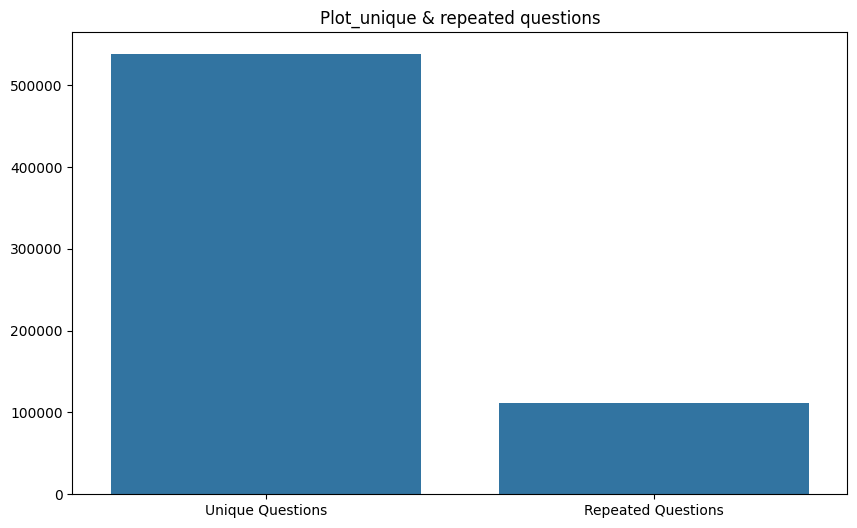

In [16]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

# Count the number of unique questions
unique_qs = len(np.unique(qids))

# Count the number of unique questions that appear more than once
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

# Calculate the percentage of unique questions that appear more than once
percentage_morethan_onetime = (qs_morethan_onetime / unique_qs) * 100

# Print the results
print('Total_unique_questions: {}\n'.format(unique_qs))
print('Number_unique_questions_more than once: {} ({}%)\n'.format(qs_morethan_onetime, percentage_morethan_onetime))
print('Max _single_question_repeated: {}\n'.format(max(qids.value_counts())))

# Plotting
x = ["Unique Questions", "Repeated Questions"]
y = [unique_qs, qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title("Plot_unique & repeated questions")
sns.barplot(x=x, y=y)
plt.show()

### NULL VALUES

In [18]:
# Checking for rows with null values
nan_rows = df[df.isnull().any(axis=1)]

if nan_rows.empty:
    print("No rows with null values found.")
else:
    print("Rows with null values:")
    print(nan_rows)

# Filling null values with empty strings
df.fillna('', inplace=True)

# Checking again for any rows with null values after filling
nan_rows_after_fill = df[df.isnull().any(axis=1)]

if nan_rows_after_fill.empty:
    print("\nAll null values have been successfully filled with empty strings.")
else:
    print("\nSome null values could not be filled. Remaining rows with null values:")
    print(nan_rows_after_fill)

No rows with null values found.

All null values have been successfully filled with empty strings.


### Feature Extraction

In [19]:
import pandas as pd
import os

# Function to calculate normalized word commonality
def normalized_word_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)

# Function to calculate normalized word total
def normalized_word_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))

# Function to calculate normalized word share
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

# Check if the CSV file exists
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    # If the file exists, read it into the DataFrame
    df = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')
else:
    # If the file does not exist, perform feature engineering and save the DataFrame to a CSV file
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    df['word_Common'] = df.apply(normalized_word_common, axis=1)
    df['word_Total'] = df.apply(normalized_word_total, axis=1)
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

    # Save the DataFrame to a CSV file
    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

# Pretty print the first few rows of the DataFrame
print("DataFrame after feature engineering:\n", df.head())


DataFrame after feature engineering:
    id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2

Minimum length of the questions in question1: 1
Minimum length of the questions in question2: 1
Number of questions with minimum length [question1]: 67
Number of questions with minimum length [question2]: 24


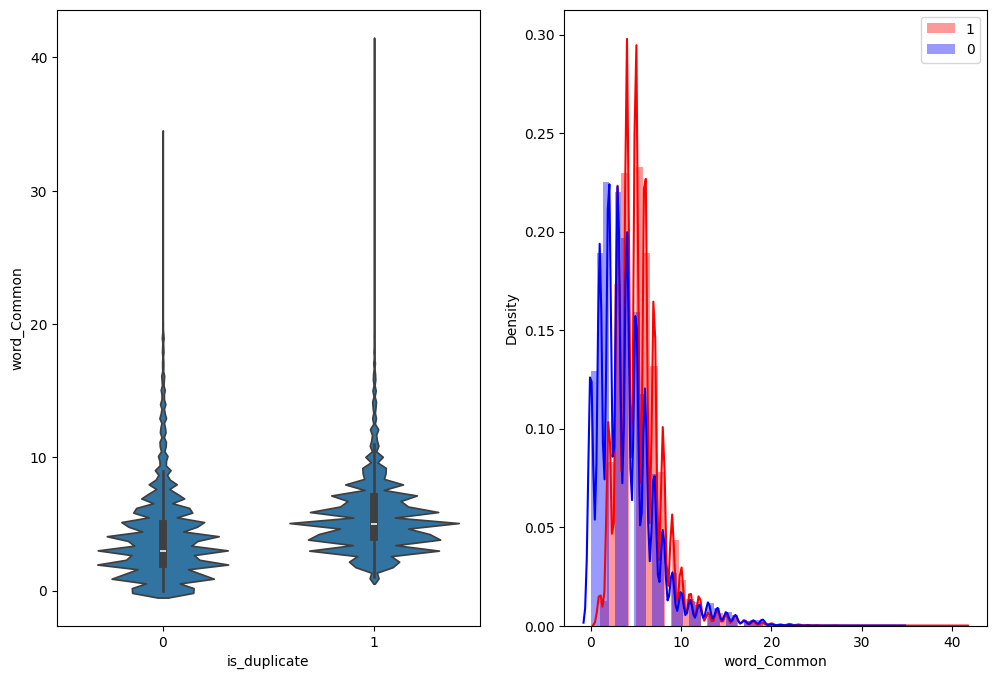

In [21]:
# Print minimum length of questions in question1 and question2
print("Minimum length of the questions in question1:", min(df['q1_n_words']))
print("Minimum length of the questions in question2:", min(df['q2_n_words']))

# Count number of questions with minimum length in question1 and question2
print("Number of questions with minimum length [question1]:", df[df['q1_n_words'] == 1].shape[0])
print("Number of questions with minimum length [question2]:", df[df['q2_n_words'] == 1].shape[0])

# Create a figure with specified size
plt.figure(figsize=(12, 8))

# Plot the first subplot (violin plot)
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_Common', data=df)

# Plot the second subplot (distribution plot)
plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'], label="1", color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'], label="0", color='blue')
plt.legend()

# Show the plots
plt.show()

### TEXT PREPROCESSING

In [24]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
# Define constants
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

# Function for text preprocessing
def preprocess(x):
    # Convert to lowercase
    x = str(x).lower()

    # Replace common abbreviations and symbols
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
         .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
         .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
         .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
         .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
         .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
         .replace("€", " euro ").replace("'ll", " will")

    # Replace numeric patterns with 'm' for million and 'k' for thousand
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)

    # Remove non-word characters and stem the text
    porter = PorterStemmer()
    pattern = re.compile('\W')
    if isinstance(x, str):
        x = re.sub(pattern, ' ', x)
        x = porter.stem(x)

        # Remove HTML tags
        example1 = BeautifulSoup(x)
        x = example1.get_text()

    return x
